In [19]:
import gym
from stable_baselines3.common.logger import configure
import stable_baselines3
from stable_baselines3 import PPO, DDPG, A2C

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray

import random
import math
from functools import partial
from scipy.stats import gamma

import json
import os
import sys
import time

import fair
from fair.io import read_properties
from fair.interface import fill, initialise

In [55]:
scenario = 'ssp245'
current_year = 2023
end_year = 2100

def ssp(scenario, category='emissions'):
    assert (category=='emissions' or category=='concentrations')
    path = '../data/fair_ssp_scenarios/' + scenario + "_" + category + ".csv"
    ssp = pd.read_csv(path).drop(['Unnamed: 0'], axis=1)
    ssp['Year'] = ssp['Year'].astype(np.int16)
    return(ssp)
ssp_df = ssp(scenario)
size = ssp_df.shape[0]

data_path = '../data/example_github_data/'
volcano_df = pd.read_csv(os.path.join(data_path, 'volcano_forcing_data.csv'), index_col='year').drop(['Unnamed: 0'], axis=1)
climate_df = pd.read_csv(os.path.join(data_path, 'climate_models_data.csv')).drop(['Unnamed: 0'], axis=1)

# cost model for CO2 and Sulfur Emissions
beta = 1.03 # estimated GDP growth rate over the year
GtC_reduce_cost = 6e11
cost_per_MT = 1000 * 1e6 # cost per ton * 10^6 tons / Mt
airplane_construction_cost = 1e8 # construction of additional airplane
cost_per_year_deployed = 12 * 8e5 # annual lease rate = 12 * monthly
payload_per_year_tons = 20 * 5  * 330 # tons/run * runs / day * operating days/year
annual_delivery_capacity = payload_per_year_tons / 1e6 # how much sulfur a single plane can emit in a year

Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change

Y.loc[:current_year-1] = 9e13 #USD/a
Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

Y[current_year] = 9.2e13 #USD/a
Y_cost[current_year] = 100*1e9 #USD/a

# basic model
species, properties = read_properties()
averages = climate_df.drop_duplicates(subset=['model'], keep='first').mean(numeric_only=True)

In [56]:
100 / annual_delivery_capacity

3030.30303030303

In [3]:
def setup_model(end_year=2105, scenario='ssp245', timesteps_per_year=1):
    
    # consider fiddling with sulfur properties since forcing seems weak and f.forcing does not include sulfur
    
    f = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    f.define_time(1750, end_year, 1/timesteps_per_year) #timepoints, timebounds
    f.define_scenarios([scenario])
    f.define_configs(['default', 'intervention'])
    f.define_species(species, properties)
    f.timesteps_per_year = timesteps_per_year
    f.allocate()

    # fill species configs using default values
    f.fill_species_configs()
    fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
    fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

    # Use climate_df for climate configs. take the average of the first runs of all models to obtain climate params
    fill(f.climate_configs['ocean_heat_capacity'], averages.loc['C1':'C3'].values)
    fill(f.climate_configs['ocean_heat_transfer'], averages.loc['kappa1':'kappa3'].values)
    fill(f.climate_configs['deep_ocean_efficacy'], averages['epsilon'])
    fill(f.climate_configs['gamma_autocorrelation'], averages['gamma'])
    fill(f.climate_configs['sigma_eta'], averages['sigma_eta'])
    fill(f.climate_configs['sigma_xi'], averages['sigma_xi'])
    fill(f.climate_configs['stochastic_run'], True)
    fill(f.climate_configs['use_seed'], True)
    fill(f.climate_configs['seed'], 1355763)

    f.fill_from_rcmip()

    volcanic_forcing = np.zeros(f.timebounds.size)
    volcanic_forcing[:timesteps_per_year*270] = volcano_df.iloc[::int(12/timesteps_per_year)].squeeze().values
    fill(f.forcing, volcanic_forcing[:, None, None], specie='Volcanic')

    initialise(f.concentration, f.species_configs['baseline_concentration'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    return(f)
ref_model = setup_model(2105, scenario, 1)
def model_reset(end_year=2105, timesteps_per_year=1): # faster than setup_model() because that function is too slow in practice
    g = fair.FAIR(ghg_method= 'meinshausen2020', ch4_method='thornhill2021')
    g.define_time(1750, end_year, 1) #timepoints, timebounds
    g.define_scenarios([scenario])
    g.define_configs(['default', 'intervention'])
    g.define_species(species, properties)
    g.allocate()
    
    g.timesteps_per_year = timesteps_per_year
    g.species_configs = ref_model.species_configs.copy(deep=True)
    g.climate_configs = ref_model.climate_configs.copy(deep=True)
    g.emissions = ref_model.emissions.copy(deep=True)
    g.concentration = ref_model.concentration.copy(deep=True)
    g.forcing = ref_model.forcing.copy(deep=True)
    g.forcing_sum = ref_model.forcing_sum.copy(deep=True)
    g.temperature = ref_model.temperature.copy(deep=True)
    g.cumulative_emissions = ref_model.cumulative_emissions.copy(deep=True)
    g.airborne_emissions = ref_model.airborne_emissions.copy(deep=True)
    g.airborne_fraction = ref_model.airborne_fraction.copy(deep=True)
    g.ocean_heat_content_change = ref_model.ocean_heat_content_change.copy(deep=True)
    g.stochastic_forcing = ref_model.stochastic_forcing.copy(deep=True)
    g.toa_imbalance = ref_model.toa_imbalance.copy(deep=True)
    
    return(g)

# Experiment 1

In [170]:
def simple_temp_reward(old_state, state, year, GDP, GDP_cost, cur_fease):
    # positive reward for temp under 1.5 goal
    return 100*(1.5 - state[0])

args = {
    'name' : "exp_1_basic_test_a2c",
    'directory' : "Experiment_1/run3", #the path in which the run will be saved
    'max_carbon' : 40,
    'max_sulfur' : 100,
    'reward_mode' : "simple_temp_reward",
    'scenario' : "ssp245",
    'current_year' : 2023,
    'end_year' : 2104,
    
    'algorithm' : "a2c",
    'learning_rate' : 0.021,
    'gamma' : 0.8, #discount factor
    'device' : 'cpu',
    'iterations' : 2000, 
    "n_steps" : 4,
    'verbose' : 2,
    'log_freq' : 100,
}

In [171]:

class Simulator(gym.Env):
    
    def __init__(self, reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'], clim_model=model_reset(),
                current_year=args['current_year'], end_year=args['end_year'], scenario=args['scenario']):
        
        super(Simulator, self).__init__()
        
        # action space for the environment, normalized for better RL training
        # the amount to increase or decrease emissions by
        self.action_space = gym.spaces.Box(
            low = np.array([-1, -1]).astype(np.float32),
            high = np.array([1, 1]).astype(np.float32),
        )
        
        self.model = clim_model 
        
        # state space, year [temp, co2_emit, sulfur_emit, co2_conc, forcing]
        """self.observation_space = gym.spaces.Box(
            low=np.array([-4, -200, -100, 0, -20.0]).astype(np.float32),
            high=np.array([5, 200, 1000, 5000, 20.0]).astype(np.float32),
        )"""
        
        self.obs_scalars = np.array([6, 300, 1000, 3000, 20], dtype=np.float32)
        
        self.observation_space = gym.spaces.Box(
            low=np.array([-1, -1, -1, -1, -1]).astype(np.float32),
            high=np.array([1,1,1,1,1]).astype(np.float32),
        )
        
        self.reward_func = eval(reward_mode) if type(reward_mode)==str else reward_mode # specify the reward function to use
        self.state = None
        self.ssp_370 = ssp('ssp370') #for feasibility testing later
        self.max_carbon = max_carbon
        self.max_aerosol = max_aerosol
        
        # setup time bounding
        self.start_year = current_year
        self.end_year = end_year
        self.time_increment = self.model.timesteps_per_year # gonna be 1
        
        # used for aerosol cost
        self.airplanes_manufactured = 0
    
        
    def reset(self):
        
        ## RESET ECONOMIC VARIABLES
        
        Y = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #global GDP
        Y_cost = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #cost of climate change
        S = pd.Series(data=np.zeros(size), index=ssp_df['Year']) #renewable knowledge stock

        S.loc[:current_year-1] = 5e11 #GJ
        Y.loc[:current_year-1] = 9e13 #USD/a
        Y_cost.loc[:current_year-1] = 100*1e9 #USD/a

        S[current_year] = 5e11 #GJ
        Y[current_year] = 9.2e13 #USD/a
        Y_cost[current_year] = 100*1e9 #USD/a
        
        ##             ##
        
        
        ## reset- faster than calling setup_model() again
        self.model = model_reset()
        self.t = self.start_year - 1
        
        self.update_state(ref_model.emissions)
        
        return(self.state[self.model.configs[1]] / self.obs_scalars)                           
    
    
    def update_state(self, emissions):
        
        self.forward_func(emissions)   
        # state is [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]   
        # state refers to at the conclusion of year X, all variables. At end, we are at beginning of year X+1
        self.state = {
            'Year' : self.t,
            self.model.configs[0] : np.array([
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[0], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[0], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[0], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[0]].item()                
            ], dtype=np.float32),
            self.model.configs[1] : np.array([ 
                self.model.temperature.loc[self.t, self.model.scenarios[0], self.model.configs[1], 0].item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], :][:2].sum().item(),
                self.model.emissions.loc[self.t - self.time_increment/2, self.model.scenarios[0], self.model.configs[1], 'Sulfur'].item(),
                self.model.concentration.loc[self.t, self.model.scenarios[0], self.model.configs[1], 'CO2'].item(),
                self.model.forcing_sum.loc[self.t, self.model.scenarios[0], self.model.configs[1]].item()
            ], dtype=np.float32)
        }
                               
        self.t += self.time_increment
    
    def access_state(self):
        return(self.state)
    
    def forward_func(self, emissions):

        self.model = model_reset()
        self.model.emissions = emissions.copy(deep=True)
        
        self.model.run(progress=False)
    
    def aerosol_cost(self, emit):
        
        # 3 factors: operating cost, construction cost, sulfur cost
        num_airplanes = emit / annual_delivery_capacity # how many airplaces deployed
        operational_cost = num_airplanes * cost_per_year_deployed
        
        num_new_airplaces = num_airplanes - self.airplanes_manufactured # number of new planes needed to service additional emissions
        construction_cost = max(num_new_airplaces, 0) * airplane_construction_cost # cost of constructing new plances
        
        sulfur_cost = emit * cost_per_MT
        
        self.airplanes_manufactured = max(int(num_airplanes), int(self.airplanes_manufactured))
        
        return(sulfur_cost + construction_cost + operational_cost)
        
    
    def render(self, mode="human"):
        if(self.state):
            print(f"Current Year: {self.state['Year']}")
            print("Without intervention:")
            config = self.model.configs[0]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
            
            print("\nWith intervention:")
            config = self.model.configs[1]
            # print the state [year, temp, co2_emit, sulfur_emit, co2_conc, forcing]
            print(f'    Temperature anomaly: {self.state[config][0]}ºC')
            print(f'    CO2 emissions: {self.state[config][1]} GtC')
            print(f'    Sulfur emissions: {self.state[config][2]} MtS')
            print(f'    CO2 concentration: {self.state[config][3]} ppm')
            print(f'    Radiative forcing: {self.state[config][4]} W/m2')
        else:
            print("No state initialized; call reset. ")
    
    
    def step(self, action):
        
        #should not call step without calling reset()
        if(not self.state): #has not been initialized
            self.reset()
    
        config = self.model.configs[1] #intervention
        old_state = self.state[config] #save for reward function
        year = self.t
        done = False
        
        
        # change emissions by action[0] from the previous year
        # emit action amount additional sulfur within same year
        new_emissions = self.model.emissions
        emit_C = self.max_carbon * action[0] + new_emissions.loc[self.t-0.5, self.model.scenarios[0], config, 'CO2 FFI'].item()
        emit_S = new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] + self.max_aerosol*abs(action[1])
        
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'CO2 FFI'] = max(emit_C, 0)
        new_emissions.loc[self.t+0.5, self.model.scenarios[0], config, 'Sulfur'] = emit_S
        
        
        # run model simulation with new values
        #state is [year, temp, emit_c, emit_s, conc_c, forcing]
        self.update_state(new_emissions) #CAUTION! self.t has now changed
        
        #Implementation of S, Y and Y_cost
        Y[year] = beta * Y[year-1] # assume constant GDP growth of beta percent
        
        emission_cost = GtC_reduce_cost * (old_state[1] - self.state[config][1])
        Y_cost[year] = (10/5 * self.state[config][0] - 2)/100 * Y[year] + self.aerosol_cost(action[1]) + emission_cost
        
        #gamma = 1 / ( 1+(S[year-1]/sigma)**rho )
        #S[year] = S[year-1] + ( (1-gamma)*Y[year-1]/epsilon - S[year-1]/tau_S ) # not used in this implementation
        
        # fail if temperature error
        if math.isnan(self.state[config][0]):
            done = True
        
        
        cur_fease = emit_C - self.ssp_370[self.ssp_370['Year']==year]['CO2-fossil (GtC/yr)'].squeeze() # positive if emitted more than default, otherwise negative
        Y[year] = Y[year] - Y_cost[year] # update GDP to reflect cost of climate change
        
        #compute the reward
        reward = self.reward_func(old_state, self.state[config], year, Y[year], Y_cost[year], cur_fease)
        

        # end the trial once 2100 is reached or if temp anomaly above 4 degrees
        if year == self.end_year or self.state[config][0] > 4: # only runs to 2100
            done = True
        
        observation = self.state[self.model.configs[1]] / self.obs_scalars
        
        return observation, reward, done, {}
        




In [172]:
env = Simulator()
print(env.action_space.sample())
print(env.reset())
obs, rew, done, _ = env.step(env.action_space.sample())
obs * env.obs_scalars, rew

[-0.05922551 -0.46072626]
[0.25729933 0.1364346  0.07996634 0.1403133  0.14759642]


(array([  1.663981 ,  41.213238 ,  79.85158  , 423.79608  ,   3.0313673],
       dtype=float32),
 -16.398096084594727)

In [45]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [150]:
def setup_dirs(args):
    save_path = os.path.join("outputs", args['directory'])
    dirs = ['plots', 'logs', 'saved_models', 'evals']
    for direc in dirs:
        path = os.path.join(save_path, direc)
        if not os.path.exists(path):
            os.makedirs(path)
    
    # save args configs
    with open(os.path.join(save_path, args['name']+'_config.txt'), 'w') as file:
        json.dump(args, file, indent=2)
    
    return save_path

def create_model(args, climate_model = model_reset(), env_type=Simulator):
    save_path = setup_dirs(args)
    
    env = env_type(reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'],
        clim_model=climate_model, scenario=args['scenario'], current_year=args['current_year'], end_year=args['end_year'])
    
    env.reset()
    
    model_builder = eval(args['algorithm'].upper()) # import from stable baselines
    model = model_builder(
        policy="MlpPolicy",
        env=env,
        learning_rate = args['learning_rate'],
        n_steps = args['n_steps'],
        gamma= args['gamma'],
        verbose=args['verbose'],
        tensorboard_log=os.path.join(save_path, 'logs', args['name']),
    )

    model.set_logger(configure(
        os.path.join(save_path, 'logs', args['name']),
        ["csv", "tensorboard"]
    ))
    
    return model, save_path


def train_model(model, save_path, args):
    
    model.learn(
        total_timesteps=args['iterations'],
        log_interval=args['log_freq'],
        eval_log_path=os.path.join(save_path, 'logs', args['name']), #eval_freq=20,
    )
    
    saved_path = os.path.join(os.path.join(save_path, 'saved_models'), args['name'])
    model.save(saved_path)
    
    return model, saved_path

VARS = ['Year', 'Temperature Anomaly (°C)', 'CO2 Emitted (GtC/yr)', 'Sulfur Emitted (MtS/yr)', 'CO2 Concentration (ppm)', 'ERF (W/m2)', 'Reward']

def evaluate_model(args, test_iters=100, climate_model= model_reset(), env_class=Simulator, debug=False):
    save_path = os.path.join("outputs", args['directory'])
    model_path = os.path.join(save_path, 'saved_models', args['name'])
    
    if(debug):
        print("Model at ", model_path)
    
    env = env_class(reward_mode=args['reward_mode'], max_carbon=args['max_carbon'], max_aerosol=args['max_sulfur'],
        clim_model=climate_model, scenario=args['scenario'], current_year=args['current_year'], end_year=args['end_year'])
    
    model = eval(args['algorithm'].upper()).load(model_path)
    progress = pd.read_csv(os.path.join(save_path, "logs/", args['name'], "progress.csv"))
    
    obs = env.reset()
    def_vals = []
    intervention_vals = []
    for i in range(test_iters):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        state = env.access_state()
        
        if(debug and i%10==0):
            print("Iteration ", i)
            print("Obs: ", obs*env.obs_scalars)
            print("action: ", action)
            env.render()
            print('\n\n')
        
        default = np.concatenate((np.array([state['Year']]), state[env.model.configs[0]], np.array([reward])))
    
        
        # get values for default and for intervention for comparison
        def_vals.append(np.concatenate((np.array([state['Year']]), state[env.model.configs[0]], np.array([reward]))))
        intervention_vals.append(np.concatenate((np.array([state['Year']]), state[env.model.configs[1]], np.array([reward]))))
        
        if(i%25==0):
            print("Iteration number: ", i)
        
        if done:
            print("\n\nSimulation concluded at iteration: ", i)
            print(env.t)
            env.render()
            env.reset()
            break;
    
    if(env.close is not None):
        env.close()
        
    return model, pd.DataFrame(data=intervention_vals, columns=VARS), pd.DataFrame(data=def_vals, columns=VARS), progress
 


# Output useful plots
def make_plots(aero_vals, def_vals, save_path):
    print(type(eval("aero_vals")))
    aero_vals.to_csv(os.path.join(save_path, 'evals', args['name'], "intervention.csv"))
    def_vals.to_csv(os.path.join(save_path, 'evals',args['name'], "default.csv"))
    
    
    plots_path = os.path.join(save_path, 'plots', args['name'])
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
    
    for col in aero_vals.columns[1:-1]:
        plt.plot(aero_vals['Year'], aero_vals[col], label='geoengineering')
        plt.plot(def_vals['Year'], def_vals[col], label='default')
        plt.ylabel(col)
        plt.xlabel('Year')
        plt.legend(loc='upper left')
        try:
            plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))
        except ValueError:
            plt.savefig(os.path.join(plots_path, col))
        plt.clf()
    
    # Plot Reward a little differently
    col = aero_vals.columns[-1]
    plt.plot(aero_vals['Year'], aero_vals[col])
    plt.plot(def_vals['Year'], def_vals[col])
    plt.ylabel(col)
    plt.xlabel('Year')
    plt.savefig(os.path.join(plots_path, col))
    

In [49]:
climate_model = model_reset()
model, save_path = create_model(args, climate_model, Simulator)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [50]:
s = time.time()
model, saved_path = train_model(model, save_path, args)
time.time() - s

750.2542629241943

In [139]:
climate_model = model_reset()
model, aero_vals, def_vals, progress_log = evaluate_model(args, 100, climate_model)

Iteration number:  0
Iteration number:  25
Iteration number:  50
Iteration number:  75


Simulation concluded at iteration:  80
2104
Current Year: 2103
Without intervention:
    Temperature anomaly: 3.3587632179260254ºC
    CO2 emissions: 9.681756019592285 GtC
    Sulfur emissions: 30.438507080078125 MtS
    CO2 concentration: 606.0589599609375 ppm
    Radiative forcing: 5.433124542236328 W/m2

With intervention:
    Temperature anomaly: 1.357147455215454ºC
    CO2 emissions: -4.608073711395264 GtC
    Sulfur emissions: 130.43850708007812 MtS
    CO2 concentration: 379.6636047363281 ppm
    Radiative forcing: 1.9364478588104248 W/m2
[ 2.02300000e+03  1.66398096e+00  4.12132378e+01  7.98515778e+01
  4.23796082e+02  3.03136730e+00 -1.63980961e+01]
[ 2.02300000e+03  1.66398096e+00  4.12132378e+01  7.98515778e+01
  4.23796082e+02  3.03136730e+00 -1.63980961e+01]


In [140]:
aero_vals

,Year,Temperature Anomaly (°C),CO2 Emitted (GtC/yr),Sulfur Emitted (MtS/yr),CO2 Concentration (ppm),ERF (W/m2),Reward
0,2023.0,1.663981,41.213238,79.851578,423.796082,3.031367,-16.398096
1,2024.0,1.411893,17.189367,179.736816,423.783447,2.345529,8.810651
2,2025.0,1.285560,3.108195,179.622055,422.083618,2.333528,21.443963
3,2026.0,1.387428,3.070394,179.507294,420.629181,2.303234,11.257160
4,2027.0,1.480599,3.032592,179.392532,419.472809,2.266189,1.940119
...,...,...,...,...,...,...,...
76,2099.0,1.076753,-4.703486,131.290085,381.709839,1.918190,42.324746
77,2100.0,1.271557,-4.751781,131.056244,381.188507,1.933887,22.844315
78,2101.0,1.220354,-4.800077,130.822388,380.661346,1.943924,27.964580
79,2102.0,1.281692,-4.704075,130.630447,380.154785,1.948990,21.830833


In [156]:
args['end_year']

2104

In [161]:
Y_cost.loc[:2103]

Year
1765    1.000000e+11
1766    1.000000e+11
1767    1.000000e+11
1768    1.000000e+11
1769    1.000000e+11
            ...     
2099    5.669034e+11
2100    1.982636e+12
2101    1.653045e+12
2102    2.070814e+12
2103    2.706262e+12
Length: 339, dtype: float64

In [169]:
os.path.join(save_path, 'GDP')

'outputs/Experiment_1/run3/GDP'

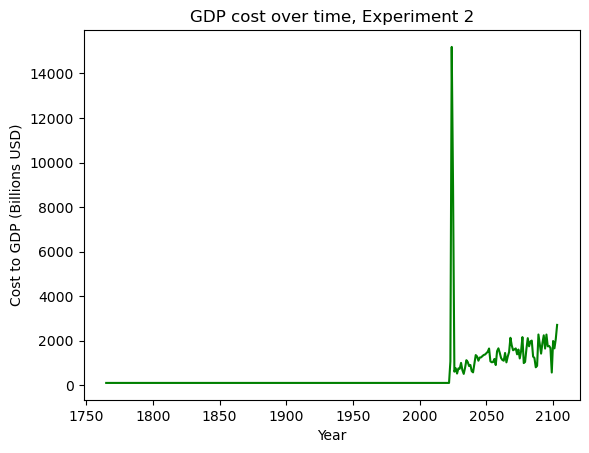

In [168]:
plt.plot(Y_cost.loc[:args['end_year']-1] / 1e12, color='g')
plt.ylabel("Trillions USD")
plt.xlabel("Year")
plt.title("Global GDP cost over time, Experiment 2")
#plt.savefig(os.path.join(save_path, 'GDP_cost'))

In [143]:
make_plots(aero_vals, def_vals, save_path)

<class 'pandas.core.frame.DataFrame'>


<Figure size 640x480 with 0 Axes>

In [68]:
Ycost = Y_cost.loc[1900:2104]
Ycost

Year
1900    1.000000e+11
1901    1.000000e+11
1902    1.000000e+11
1903    1.000000e+11
1904    1.000000e+11
            ...     
2100    0.000000e+00
2101    0.000000e+00
2102    0.000000e+00
2103    0.000000e+00
2104    0.000000e+00
Length: 205, dtype: float64

## End of Century Results - Pandas Analysis of Saved Dataframes

In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
data_path = "outputs/Experiment_1/run3/evals"

aerosols = pd.read_csv(os.path.join(data_path, "exp_1_basic_test_a2c_intervention.csv")).drop(['Unnamed: 0'], axis=1)
default = pd.read_csv(os.path.join(data_path, "exp_1_basic_test_a2c_default.csv")).drop(['Unnamed: 0'], axis=1)

In [7]:
aerosols[aerosols['CO2 Emitted (GtC/yr)'] > 0] # net zero in 2054

,Year,Temperature Anomaly (°C),CO2 Emitted (GtC/yr),Sulfur Emitted (MtS/yr),CO2 Concentration (ppm),ERF (W/m2),Reward
0,2023.0,1.663981,41.213238,79.851578,423.796082,3.031367,-16.398096
1,2024.0,1.411893,17.189367,179.736816,423.783447,2.345529,8.810651
2,2025.0,1.285560,3.108195,179.622055,422.083618,2.333528,21.443963
3,2026.0,1.387428,3.070394,179.507294,420.629181,2.303234,11.257160
4,2027.0,1.480599,3.032592,179.392532,419.472809,2.266189,1.940119
5,2028.0,1.318356,2.994791,179.277756,418.521729,2.239076,18.164396
6,2029.0,1.456190,2.956989,179.162994,417.615906,2.226461,4.381013
7,2030.0,1.438781,2.919188,179.048233,416.859985,2.204700,6.121886
8,2031.0,1.587799,2.881386,178.933472,416.163971,2.193360,-8.779919
9,2032.0,1.371232,2.809679,177.690247,415.566284,2.187208,12.876809


In [54]:
aerosols[aerosols['Year']==2100]

,Year,Temperature Anomaly (°C),CO2 Emitted (GtC/yr),Sulfur Emitted (MtS/yr),CO2 Concentration (ppm),ERF (W/m2),Reward
77,2100.0,1.271557,-4.751781,131.056244,381.188507,1.933887,22.844315


In [11]:
default[default['Year']==2100]

,Year,Temperature Anomaly (°C),CO2 Emitted (GtC/yr),Sulfur Emitted (MtS/yr),CO2 Concentration (ppm),ERF (W/m2),Reward
77,2100.0,3.241175,10.347013,31.056242,605.666077,5.402644,22.844315


In [31]:
ssp_df = ssp_df[ssp_df['Year'] < 2104][ssp_df['Year'] > 2022]

In [33]:
ssp_emissions = ssp_df['CO2-fossil (GtC/yr)'] + ssp_df['CO2-landuse (GtC/yr)']
ssp_emissions.values

array([11.32397267, 11.40116121, 11.47834975, 11.5555383 , 11.63272684,
       11.70991538, 11.78710392, 11.86429246, 11.88549178, 11.90669109,
       11.9278904 , 11.94908972, 11.97028903, 11.99148835, 12.01268766,
       12.03388698, 12.05508629, 12.0762856 , 12.05470772, 12.03312983,
       12.01155195, 11.98997407, 11.96839618, 11.9468183 , 11.92524041,
       11.90366253, 11.88208464, 11.86050676, 11.7713881 , 11.68226945,
       11.5931508 , 11.50403214, 11.41491349, 11.32579483, 11.23667618,
       11.14755753, 11.05843887, 10.96932022, 10.83393684, 10.69855347,
       10.56317009, 10.42778672, 10.29240334, 10.15701996, 10.02163659,
        9.88625321,  9.75086984,  9.61548646,  9.38633696,  9.15718746,
        8.92803797,  8.69888847,  8.46973897,  8.24058947,  8.01143998,
        7.78229048,  7.55314098,  7.32399148,  7.03707278,  6.75015407,
        6.46323536,  6.17631666,  5.88939795,  5.60247925,  5.31556054,
        5.02864184,  4.74172313,  4.45480442,  4.27356196,  4.09

In [52]:
diff = aerosols['Sulfur Emitted (MtS/yr)'] - default['Sulfur Emitted (MtS/yr)']
diff[diff<99.99999]

0    0.0
Name: Sulfur Emitted (MtS/yr), dtype: float64

In [12]:
aerosols.head()

,Year,Temperature Anomaly (°C),CO2 Emitted (GtC/yr),Sulfur Emitted (MtS/yr),CO2 Concentration (ppm),ERF (W/m2),Reward
0,2023.0,1.663981,41.213238,79.851578,423.796082,3.031367,-16.398096
1,2024.0,1.411893,17.189367,179.736816,423.783447,2.345529,8.810651
2,2025.0,1.285560,3.108195,179.622055,422.083618,2.333528,21.443963
3,2026.0,1.387428,3.070394,179.507294,420.629181,2.303234,11.257160
4,2027.0,1.480599,3.032592,179.392532,419.472809,2.266189,1.940119


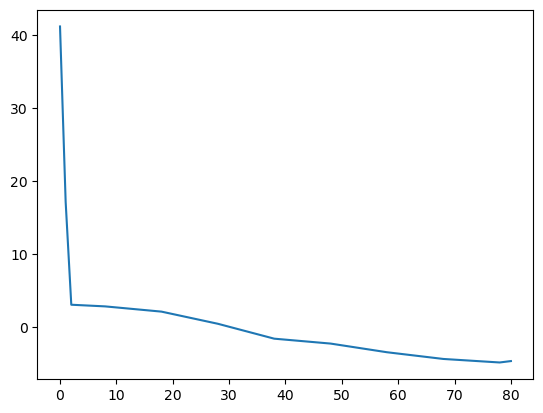

In [10]:
plt.plot(aerosols['CO2 Emitted (GtC/yr)'])

In [59]:
# cost model for CO2 and Sulfur Emissions
beta = 1.03 # estimated GDP growth rate over the year
GtC_reduce_cost = 6e11
cost_per_MT = 1000 * 1e6 # cost per ton * 10^6 tons / Mt
airplane_construction_cost = 1e8 # construction of additional airplane
cost_per_year_deployed = 12 * 8e5 # annual lease rate = 12 * monthly
payload_per_year_tons = 20 * 5  * 330 # tons/run * runs / day * operating days/year
annual_delivery_capacity = payload_per_year_tons / 1e6

(100 * airplane_construction_cost/ annual_delivery_capacity)*1e-9

303.03030303030306

In [70]:
100 / annual_delivery_capacity

3030.30303030303

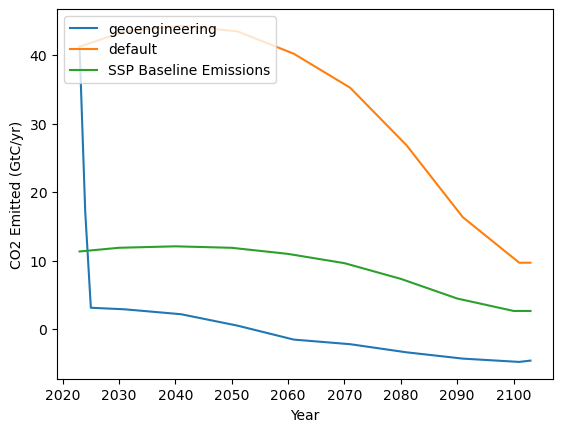

In [38]:
col = 'CO2 Emitted (GtC/yr)'
plt.plot(aerosols['Year'], aerosols[col], label='geoengineering')
plt.plot(default['Year'], default[col], label='default')
plt.plot(aerosols['Year'], ssp_emissions.values, label='SSP Baseline Emissions')

plt.ylabel(col)
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.savefig("CO2_emissions")

In [ ]:
try:
    plt.savefig(os.path.join(plots_path, col[:col.index("(")-1]))
except ValueError:
    plt.savefig(os.path.join(plots_path, col))